# Gaussian Quadrature
## January 17th, 2022
### Overview: Implementations of Gaussian quadrature to approximate integrals

In [6]:
import numpy as np
from scipy.stats import norm
from scipy import sparse as sp
from scipy import linalg as la
from matplotlib import pyplot as plt
from scipy.integrate import quad

In [7]:
class GaussianQuadrature:
    """Class for integrating functions on arbitrary intervals using Gaussian
    quadrature with the Legendre polynomials or the Chebyshev polynomials.
    """
    # Problems 1 and 3
    def __init__(self, n, polytype="legendre"):
        """Calculate and store the n points and weights corresponding to the
        specified class of orthogonal polynomial (Problem 3). Also store the
        inverse weight function w(x)^{-1} = 1 / w(x).

        Parameters:
            n (int): Number of points and weights to use in the quadrature.
            polytype (string): The class of orthogonal polynomials to use in
                the quadrature. Must be either 'legendre' or 'chebyshev'.

        Raises:
            ValueError: if polytype is not 'legendre' or 'chebyshev'.
        """
        #raising errors
        if polytype != "legendre" and polytype != "chebyshev":
            raise ValueError("Invalid Polytype")
            
        #storing n and poly type
        self.n = n
        self.polytype = polytype
        
        #getting w(x)
        if polytype == 'legendre':
            w = lambda x:1
        else:
            w = lambda x: 1/(np.sqrt(1-(x**2)))
        
        #storing points and weights
        self.points, self.w = self.points_weights(n)
        self.inv_w = lambda x: 1/w(x)

    # Problem 2
    def points_weights(self, n):
        """Calculate the n points and weights for Gaussian quadrature.

        Parameters:
            n (int): The number of desired points and weights.

        Returns:
            points ((n,) ndarray): The sampling points for the quadrature.
            weights ((n,) ndarray): The weights corresponding to the points.
        """
        #forming betas according to type, and alpha
        if self.polytype == "legendre":
            B = np.array([k**2/(4*k**2 - 1) for k in range(1,n)])
        elif self.polytype == "chebyshev":
            B = np.array([1/2]+[1/4]*(n-2))
        a = np.zeros(n)
        
        #constructing Jacobian
        diagls = [np.sqrt(B),a,np.sqrt(B)]
        J = sp.diags(diagls, [-1,0,1])
        J = sp.csr_matrix.todense(J)
        
        #getting xi points (eigenvalues of J) and right eigenvectors
        vals,vecs = la.eig(J)
        vecs = vecs.T
        w = []
        if self.polytype == "legendre":
            for vec in vecs:
                w.append(vec[0]**2 * 2)
        elif self.polytype == "chebyshev":
            for vec in vecs:
                w.append(vec[0]**2 * np.pi)
                
        return vals, np.array(w)

    # Problem 3
    def basic(self, f):
        """Approximate the integral of a f on the interval [-1,1]."""
        #creating g as lambda function
        g = lambda x: f(x) * self.inv_w(x)
        
        #dotting to get hadamard and sum
        return np.dot(g(self.points),self.w)

    # Problem 4
    def integrate(self, f, a, b):
        """Approximate the integral of a function on the interval [a,b].

        Parameters:
            f (function): Callable function to integrate.
            a (float): Lower bound of integration.
            b (float): Upper bound of integration.

        Returns:
            (float): Approximate value of the integral.
        """
        #creating h rescaling of f
        h = lambda x: f( ((b-a)/2)*x + ((a+b)/2) )
        
        #getting integral of h with self.basic and scaling back
        return ((b-a)/2) * self.basic(h)

    # Problem 6.
    def integrate2d(self, f, a1, b1, a2, b2):
        """Approximate the integral of the two-dimensional function f on
        the interval [a1,b1]x[a2,b2].

        Parameters:
            f (function): A function to integrate that takes two parameters.
            a1 (float): Lower bound of integration in the x-dimension.
            b1 (float): Upper bound of integration in the x-dimension.
            a2 (float): Lower bound of integration in the y-dimension.
            b2 (float): Upper bound of integration in the y-dimension.

        Returns:
            (float): Approximate value of the integral.
        """
        #defining h
        h = lambda x,y: f( ((b1-a1)/2)*x + ((a1+b1)/2), ((b2-a2)/2)*y + ((a2+b2)/2)  )
        
        #defining g
        g = lambda x,y: h(x,y)*self.inv_w(x)*self.inv_w(y)
        
        #big coefficient
        coeff = (b1-a1)*(b2-a2)/4
        
        #approximating integral
        approx = 0
        for i in range(self.n):
            for j in range(self.n):
                approx += self.w[j]*self.w[i]*g(self.points[i], self.points[j])
        
        return coeff*approx

In [8]:
# Problem 5
def prob5():
    """Use scipy.stats to calculate the "exact" value F of the integral of
    f(x) = (1/sqrt(2 pi))e^((-x^2)/2) from -3 to 2. Then repeat the following
    experiment for n = 5, 10, 15, ..., 50.
        1. Use the GaussianQuadrature class with the Legendre polynomials to
           approximate F using n points and weights. Calculate and record the
           error of the approximation.
        2. Use the GaussianQuadrature class with the Chebyshev polynomials to
           approximate F using n points and weights. Calculate and record the
           error of the approximation.
    Plot the errors against the number of points and weights n, using a log
    scale for the y-axis. Finally, plot a horizontal line showing the error of
    scipy.integrate.quad() (which doesn’t depend on n).
    """
    #getting the "exact" value for the integral from -3 to 2
    exact = norm.cdf(2) - norm.cdf(-3)
    
    #making Ns and error lists
    N = np.arange(5,55,5)
    EgqL = []
    EgqC = []
    
    #f function to integrate
    f = lambda x: (1/np.sqrt(2*np.pi)) * np.exp( -(x**2)/2 )
    
    #for each n,
    for n in N:
        #make Gaussian Quad to approx the integral
        gqL = GaussianQuadrature(n=n)
        approxL = gqL.integrate(f,-3,2)
        gqC = GaussianQuadrature(polytype='chebyshev',n=n)
        approxC = gqC.integrate(f,-3,2)
        
        #get errors
        errorL = np.abs(exact - approxL)
        errorC = np.abs(exact - approxC)
        EgqL.append(errorL)
        EgqC.append(errorC)
    
    #doing scipy.integrate.quad
    quad_err = [np.abs(exact - quad(f,-3,2))[0]]*len(N)
    
    #plot errors against n values
    plt.title("approximation error for different integral approximations")
    plt.plot(N,EgqL,'r',label='legendre error')
    plt.plot(N,EgqC,'k',label='cheby error')
    plt.plot(N,quad_err,'b',label='quad error')
    plt.ylabel("absolute error")
    plt.xlabel("n")
    plt.yscale('log')
    plt.legend()


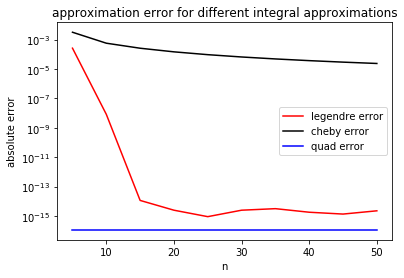

In [9]:
prob5()